# Estimating Signal Amplitude and Phase

Until now, we have assumed that the received signal is known completely - except for the information symbols and the additive noise. In reality, several signal parameters are unknown, including
* signal amplitude $A$
* carrier phase $\phi$
* carrier frequency offset $\Delta f$
* signal delay $\tau$

The receiver can **not** recover the information symbols without knowing and correcting for these unknown signal parameters.

The unknown signal parameters must be measured (estimated) from the received signal. Usually, this is accomplished by sending a training sequence of known symbols before the information bearing signal.

Signal parameters are determined from this training sequence and are then used to enable the transmitter to receive the information symbols.

Today, we illustrate the principles of this procedure by estimating the complex amplitude (phasor) $Ae^{j\phi}$ of the signal. This is the easiest signal parameter to estimate. We will continue to assume that the signal is synchronized in time (delay $\tau=0$) and frequency (offset $\Delta f = 0$).

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/050_phasor_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/050_phasor_estimation.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constellation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [4]:
def srrc_pulse(a, fsT, N=5):
    r"""Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - length of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [5]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [6]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [7]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

## Maximum Likelihood Estimation of Phasor

### Training Signal

Our goal is to demonstrate how the phasor $Ae^{j\phi}$ can be estimated from a received training sequence. The training signal (usually) has the same form as the information bearing signal, except all the training symbols $p_n$ are known. 

For the estimation of the phasor, the choice of training symbols is not critical. We will see that for estimating the signal delay, i.e., for time synchronization, good autocorrelation properties of the training sequence are critical.

Hence, our training signal will be derived from $N_p$ randomly selected information symbols $p_n$. We can write our training signal as
$$
    s_p(t) = \sum_{n=0}^{N_p-1} p_n p(t-nT),
$$
where $p(t)$ is a suitable pulse shape for symbol period $T$.

For our experiments, we will assume that the training symbols are drawn randomly from a 16-QAM constellation $\cal A$. For pulse-shaping, a square-root raised-cosine (SRRC) filter with roll-off $a=0.5$ is used. To ensure that time-domain plots are smooth, the signal is sampled 32 times per symbol period (`fsT = 32`).

In [8]:
## Parameters
# pulse shaping
fsT = 32
a = 0.5
N = 5

hh = srrc_pulse(a, fsT, N)

# constellation: 16-QAM, normalized to unit average energy per symbol
Alphabet = np.array([a +1j*b for a in [-3, -1, 1, 3] for b in [-3, -1, 1, 3]]) / np.sqrt(10)

# number of training symbols
Np = 16

In [9]:
## construct the training signal
# training symbols
pn = random_symbols(Alphabet, Np)

# pulse shaping
sp = pulse_shape(pn,hh, fsT)

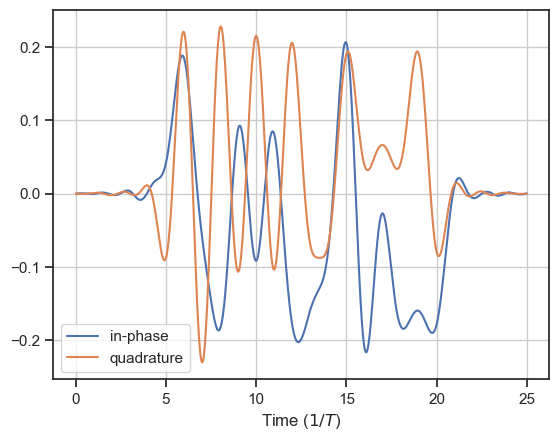

In [10]:
tt = np.arange(len(sp))/fsT
plt.plot(tt, np.real(sp), label="in-phase")
plt.plot(tt, np.imag(sp), label="quadrature")

plt.grid()
plt.xlabel('Time ($1/T$)')
plt.legend()

plt.show()

### Channel

The channel multiplies the training signal with the complex phasor $Ae^{j\phi}$ - this phasor is unknown at the receiver. It is critical that both amplitude $A$ and phase $\phi$ are estimated accurately.

If the phase is not estimated correctly, then the 16-QAM constellation is rotated. If the amplitude is not estimated correctly, then the constellation is scaled. In either case, the error probability will increase.

Additionally, the channel adds complex, whithe Gaussian noise of specified SNR. Note, that noise variance must be multiplied by $A^2$ (relative to no channel gain) to maintain correct SNR.

In [11]:
## Channel parameters
A = 0.1
phi = np.pi/4
X = A*np.exp(1j*phi) # phasor

SNR_dB = 20  # a little high because we're using 16-QAM 
SNR_lin = 10**(SNR_dB/10)
noise_var = A**2 / SNR_lin  # total noise variance in I and Q

In [12]:
## received training signal
rp = X * sp + np.sqrt(0.5 * noise_var) * (np.random.randn(len(sp)) + 1j*np.random.randn(len(sp)))

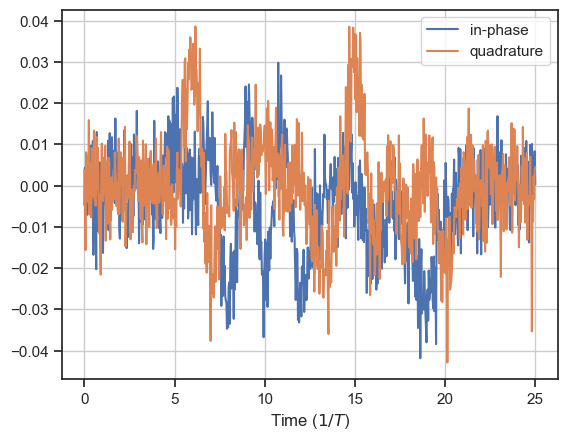

In [13]:
plt.plot(tt, np.real(rp), label="in-phase")
plt.plot(tt, np.imag(rp), label="quadrature")

plt.grid()
plt.xlabel('Time ($1/T$)')
plt.legend()

plt.show()

The received signal is
* noisy
* scaled
* phase shifted

### Estimation

We have shown that the maximum-likelihodd estimate (MLE) for the phasor $X = Ae^{j\phi}$ can be computed from samples of the received signal $r[n]$ and samples of the training signal $s_p[n]$:
$$
\hat{X} = \frac{\sum_n r[n]s^*[n]}{\sum_n |s[n]|^2}
$$

For the given signals $r[n]$ and $s_p[n]$ this yields:

In [14]:
## compute the estimate of the phasor
X_hat = np.sum(rp*sp.conj())/np.sum(sp*sp.conj())

print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))

print("Corrected phasor X/X_hat = {:4.3f} + j {:4.3f}". format(np.real(X/X_hat), np.imag(X/X_hat)))

Estimated amplitude: 0.101
Estimated phase: 0.240 * pi
Corrected phasor X/X_hat = 0.987 + j 0.030


### Computing the phasor from matched filter outputs

Above we computed the phasor estimate from samples of the received signal $r[n]$ and samples of the training signal $s_p[n]$. 

Let's take a look at the numerator of the estimator $C_{rs} = \sum_n r[n]s^*[n]$. If we insert our expression for the training signal, the numerator becomes
$$
    C_{rs} = \sum_n r[n]s^*[n] = \sum_n r[n] \sum_k p^*_k p^*[n - k \cdot f_sT] = \sum_k p^*_k \sum_n r[n] p^*[n - k \cdot f_sT].
$$

Notice that $Z_k = \sum_n r[n] p^*[n - k \cdot f_sT]$ are the outputs of the matched filter $p^*[-n]$ at sampling instances $k \cdot f_sT$.

Therefore, we can alternatively compute the numerator of the estimate from the matched filter outputs and the training symbols:
$$
    C_{RS}  = \sum_{k=0}^{N_p-1} Z_k p^*_k.
$$
Remember that the filter delays must be taken into account when identifying the proper sampling instances.

By a similar argument, it follows that the denominator of the estimate is simply $\sum_{k=0}^{N_p-1} |p_k|^2$, so that the phasor estimate based on matched filter outputs $Z_k$ and training symbols $p_k$ is given by
$$
    \hat{X} = \frac{\sum_{k=0}^{N-1} Z_k p^*_k}{\sum_{k=0}^{N-1} |p_k[^2}.
$$

In [15]:
## Compute matched filter outputs and matched filter samples
mf_out = np.convolve(rp, np.flip(hh))

# down-sample starting at filter delay
d_samples = len(hh) - 1
Z = mf_out[d_samples::fsT][:Np]

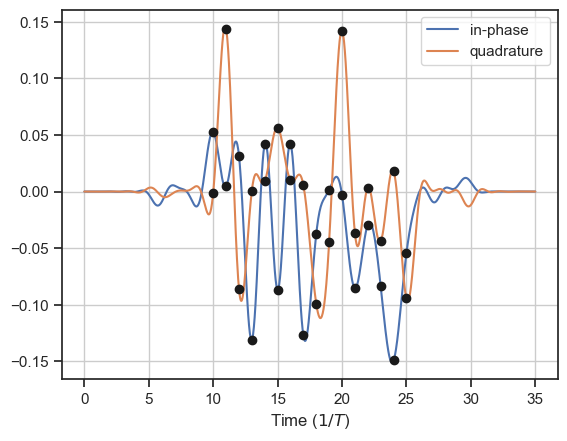

In [16]:
tt = np.arange(len(mf_out)) / fsT
tt_samples = tt[d_samples::fsT][:Np]

plt.plot(tt, np.real(mf_out), label="in-phase")
plt.plot(tt, np.imag(mf_out), label="quadrature")

plt.plot(tt_samples, np.real(Z), 'ko')
plt.plot(tt_samples, np.imag(Z), 'ko')

plt.grid()
plt.xlabel('Time ($1/T$)')
plt.legend()

plt.show()

In [17]:
X_hat = np.sum(Z * pn.conj())/np.sum(pn*pn.conj())

print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))

print("Corrected phasor X/X_hat = {:4.3f} + j {:4.3f}". format(np.real(X/X_hat), np.imag(X/X_hat)))

Estimated amplitude: 0.101
Estimated phase: 0.240 * pi
Corrected phasor X/X_hat = 0.988 + j 0.030


The estimate based on matched filter outputs matches the estimate based on samples.

We capture our findings by creating a function for estimating the phasor based on matched filter outputs.

In [18]:
def estimate_phasor_mf(Zk, pk):
    """Estimate phasor from matched filter outputs
    
    Inputs:
    Zk - matched filter outputs
    pk - training symbols

    Returns:
    complex scalar - estimated phasor
    """
    return np.sum(Zk * pk.conj())/np.sum(pk*pk.conj())

## Using the phasor estimate in the receiver

The received signal consists of the training signal followed by the information bearing signal. The receiver will 

* pass both portions of the received signal through its matched filter,
* the matched filter outputs are sampled at the symbol locations (i.e., down-sampled by `fsT` starting at the filter delay).
*  The first $N_p$ outputs are the training symbols; these are used to form the phasor estimate $\hat{X}$.
* The remaining matched filter outputs $Z_k$ are scaled by $1/\hat{X} = \frac{\hat{X}^*}{|\hat{X}|^2}$.
* The scaled matched filter outputs are then input to the decision rule to make final symbol decisions.

These steps are illustrated below for a burst of symbols.

In [19]:
## generate the transmitted signal
Ns = 1024
syms = random_symbols(Alphabet, Ns)

# concatenate training and symbols, then pulse shape
sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)


In [20]:
## channel: scale by A e^{j\phi}, then add noise
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi) # phasor

SNR_dB = 20  # a little high because we're using 16-QAM 
SNR_lin = 10**(SNR_dB/10)
noise_var = A**2 / SNR_lin  # total noise variance in I and Q

rr = X * sig + np.sqrt(0.5 * noise_var) * (np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))

In [21]:
## receiver processing
# 1. pass rr through matched filter
mf_out = np.convolve(rr, np.flip(hh))

# 2. down-sample
Z = mf_out[d_samples::fsT][:Np + Ns]

# 3. form the estimate from the first Np samples of Z
X_hat = estimate_phasor_mf(Z[:Np], pn)

# 4. scale the MF outputs during the information portion
Z_scaled = Z[Np:] * 1/X_hat

# 5. make bit decisions
dec = MPE_decision_rule(Z_scaled, Alphabet)

# summarize results
print("Estimated amplitude: {:4.3f}\nEstimated phase: {:4.3f} * pi".format(np.abs(X_hat), 
                                                                           np.angle(X_hat)/np.pi))

print("Found {:d} errors".format(np.sum(np.not_equal(dec, syms))))

Estimated amplitude: 0.252
Estimated phase: 0.263 * pi
Found 0 errors


### Constellations

For additional insight, we plot the constellation at different points in the process. We begin with the transmitted, ideal constellation. Then, show the received (scaled and rotated) constellation and, finally, the recovered constellation after scaling with the estimated phasor.

The corrected constellation is very close to the transmitted constellation. In contrast, the received constellation is not usable.

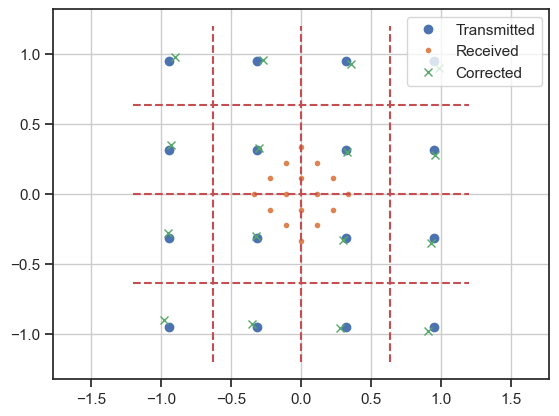

In [22]:
# Plot of constellation at different points in the process
plt.plot(np.real(Alphabet), np.imag(Alphabet), 'o', label="Transmitted")
plt.plot(np.real(X*Alphabet), np.imag(X*Alphabet), '.', label="Received")
plt.plot(np.real(X/X_hat*Alphabet), np.imag(X/X_hat*Alphabet), 'x', label="Corrected")
plt.grid()
for n in range(3):
    plt.plot(1.2*np.array([-1,1]), (-2+n*2)/np.sqrt(10)*np.ones(2) , 'r--')
    plt.plot((-2+n*2)/np.sqrt(10)*np.ones(2) , 1.2*np.array([-1,1]), 'r--')

plt.axis('equal')
plt.legend()

plt.show()

Next, we look at a scatter plot of the received symbols (after matched filter and correction). Since, no errors were observed above, we expect that the scatter plot shows tight clusters that are confined to the correct decision regions.

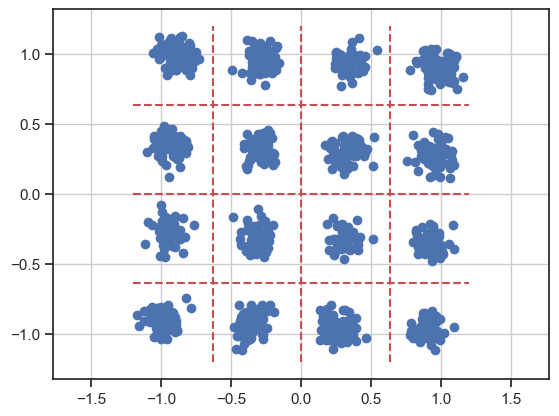

In [23]:
# Plot of constellation at different points in the process
plt.plot(np.real(Z_scaled), np.imag(Z_scaled), 'o', label="Corrected")

plt.grid()
for n in range(3):
    plt.plot(1.2*np.array([-1,1]), (-2+n*2)/np.sqrt(10)*np.ones(2) , 'r--')
    plt.plot((-2+n*2)/np.sqrt(10)*np.ones(2) , 1.2*np.array([-1,1]), 'r--')

plt.axis('equal')

plt.show()

### Error Vector Magnitude (EVM)

Error vector magnitude (EVM) is a measure for the quality of the received modulated signal. It can be computed from constellation diagrams like the one shown above.

The error vector for the $n$-th received symbol is the (absolute value of the) difference between the $n$-th corrected, matched filter output, $\frac{Z_n}{\hat{X}}$ and the corresponding true symbol $s_n$. In practice, the estimated symbol is used if the true symbol is not known. The error vector, $\mathbf{e}$, is therefore:
$$
\mathbf{e}_n = |\frac{Z_n}{\hat{X}} - s_n|.
$$

The error vector magnitude is obtained by computing the RMS value of the error vectors $\mathbf{e}_n$ and scaling it by the standard deviation of the constellation,
$$
\text{EVM}_{\text{RMS}} = \frac{\sqrt{\frac{1}{N} \sum_{n=0}^{N-1}|\frac{Z_n}{\hat{X}} - s_n|^2}}{\sqrt{\frac{1}{M} \sum_{m=0}^{M-1}|s_n|^2}}.
$$

EVM is often expressed in percent. 

Note, that for the RMS definition of EVM, 
$$
\text{EVM}_{\text{RMS}} \approx \frac{1}{\sqrt{\text{SNR}_{\text{linear}}}}.
$$

In [26]:
## Compute EVM for observed signal
err_vecs = np.abs(Z_scaled - syms)
EVM = np.sqrt( np.mean(err_vecs ** 2)) / np.sqrt(np.mean(np.abs(Alphabet)**2))

print(f"Error Vector Magnitude (EVM) = {100 * EVM :5.2f}%")

Error Vector Magnitude (EVM) = 10.65%


### Monte Carlo Simulation

As before, we conduct a Monte Carlo Simulation to assess the symbol error probability. 

Since the phasor of the received signal is unknown and must be estimated, the error probability will be increased relative to that for a known amplitude and phase. The exact error probability is difficult to compute and simulations are an appropriate means to obtain an estimate of the error rate.

Besides, measuring the error rate, we also collect the estimated phasors so that we can analyze it's statistics.

In [27]:
## Simulation parameters
# parameters
from random import random


fsT = 16
N = 5
a = 0.5

pp = srrc_pulse(a, fsT, N)   # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1      # filter delay

SNR_dB = 17
SNR = 10**(SNR_dB/10)
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi)

# Alphabet remains 16-QAM
Ns = 1024                    # number of symbols per burst
Np = 16
pn = random_symbols(Alphabet, Np)

# simulation parameters
max_bursts = 1000
max_errors = 400

N_bursts = 0
N_errors = 0

# list for storing estimates
all_X_hat = []

In [28]:
# the Monte Carlo loop
while N_bursts < max_bursts and N_errors < max_errors:
    # Transmitter
    sym = random_symbols(Alphabet, Ns)
    ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
    # Channel
    rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
    # receiver
    mf_out = np.convolve(rr, np.flip(pp))
    Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
    X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
    dec = MPE_decision_rule(Z[Np:]*1/X_hat, Alphabet) # decisions on corrected symbols

    # update simulation statistics
    N_bursts += 1
    N_errors += np.sum(np.not_equal(dec, sym))
    all_X_hat.append(X_hat)

print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
print("The exact value for the symbol error rate is: {:8.6f}".format(3*Q(np.sqrt(SNR/5)) - 9/4*Q(np.sqrt(SNR/5))**2))

Found 400 errors in 136192 symbols; estimated symbol error rate 0.002937
The exact value for the symbol error rate is: 0.002317


### Estimation Accuracy

In the simulations above, we stored all estimates $\hat{X}$ of the phasor $X$. That allows us to analyze the statistical properties of the estimator.

We begin with a scatter plot of all estimates in the complex plane.

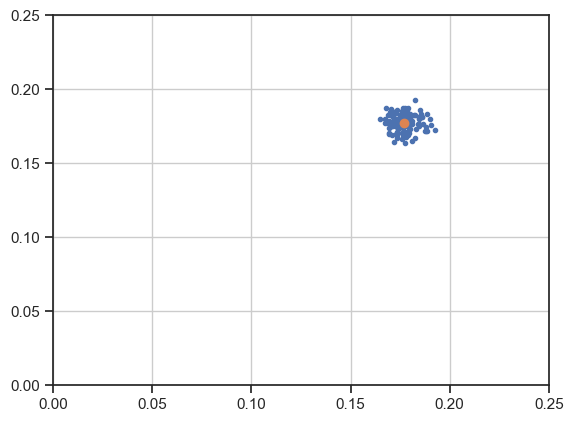

In [29]:
all_X_hat = np.array(all_X_hat)

plt.plot(all_X_hat.real, all_X_hat.imag, '.')
plt.plot(X.real, X.imag, 'o')
plt.grid()

plt.xlim(0, A)
plt.ylim(0, A)

plt.show()


The scatter plot shows a tight cluster of estimates around the true value of $X$. 

Next, we compute the mean over all estimates and compare it to the true value. According to the theory discussed in class, the estimator is unbiased so that the average of all estimates should be very close to the true value.

Similarly, we can compute the variance (or standard deviation). We have shown that the variance of $\hat{X}$ is given by
$$
\text{Var}[\hat{X}] = \frac{\sigma_N^2}{\sum_{k=1}^{N_p-1} |s_k|^2}.
$$
In the simulations, the noise variance $\sigma_N^2 = \frac{A^2}{\text{SNR}}$.

In [28]:
print('Statistics of estimator X_hat:')
print('True X = {:4.3f} + j{:4.3f}'.format(X.real, X.imag))
m_X_hat = np.mean(all_X_hat)
print('Mean = {:4.3f} + j{:4.3f}'.format(m_X_hat.real, m_X_hat.imag))
s_X_hat = np.std(all_X_hat)
print('Standard Deviation = {:5.4f}, theoretical: {:5.4f}'.format(s_X_hat, 
                                                                  np.sqrt(A**2/SNR / np.sum(np.abs(pn)**2))))

Statistics of estimator X_hat:
True X = 0.177 + j0.177
Mean = 0.176 + j0.178
Standard Deviation = 0.0088, theoretical: 0.0084


The results are in very good agreement with our expectations.

## Blind Estimation

So far, we have focused on the (usual) case of estimating the phasor $X$ with the help of a training sequence.

It is possible, however, to estimate the phasor without a training sequence. The only knowledge we assume is that we know the signal constellation and we will also need to know the noise variance - at least aproximately. It is further assume that the prior distribution of the symbols is uniform.

This procedure becomes more cumbersome with large constellations. Hence, we will restrict ourselves to BPSK symbols. We denote by $p_n$ a sequence of (unknown) BPSK symbols.

Looking at a single symbol $p$, the received symbol $Z$ (i.e., the matched filter output) is
$$
    Z = X \cdot p + N,
$$
where $X$ is the unknown phasor and $N$ is complex, Gaussian noise.

Since we only know that $p$ is either 1 or -1 with equal probability, the density of $Z$ is not Gaussian but a mixture of two Gaussians.
If $x=x$, this density is
$$
p(z|x) = \frac{1}{2} \frac{1}{\pi \sigma^2} e^{\frac{|z-x|^2}{\sigma^2}} + \frac{1}{2} \frac{1}{\pi \sigma^2} e^{\frac{|z+x|^2}{\sigma^2}}.
$$

The first term represents the case that $p=1$ and the second is for $p=-1$; each has probability $\frac{1}{2}$ of occuring.

With a given Observation $Z=z$, we can still maximize this likelihood (density) with respect to the phasor $x$. I.e., the maximum likelihood estimate for $X$ is still
$$
\hat{X} = \arg \max_x p(Z|x). 
$$
However, the maximization is a little more difficult than with known training symbols.

Taking the (Wirtinger) derivative of $p(Z|x)$ with respect to $x$, it can be shown that $\hat{X}$ is the solution of the transcendental equation
$$
x = Z \cdot \tanh\left(\frac{2 \Re\{Z^*x\}}{\sigma^2}\right).
$$
While a closed-form solution is not possible, a few observations can be made:

* The phase of $X$ will equal the phase of $Z$ since the $\tanh(\cdot)$ term is real-valued
* If $X$ is a solution, then $-X$ is also a solution; the ambiguity regarding the sign of $p$ carries over to the estimate.
* The expression $\hat{p} = \tanh\left(\frac{2 \Re\{Z^*x\}}{\sigma^2}\right)$ can be interpreted as a "soft" decision on the training symbol $p$. If the expression inside parentheses is large, then $\hat{p}$ will be 1 or -1 depending on the polarity of the argument of $\tanh(\cdot)$. Otherwise, $\hat{p}$ will be between -1 and 1. 

The last item follows from the shape of the hyperbolic tangent.

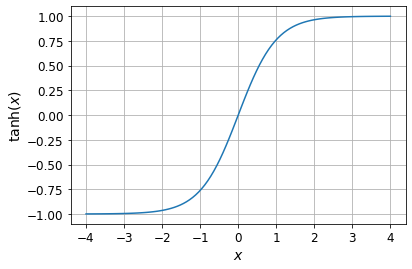

In [74]:
## plot( tanh(x))
x = np.linspace(-4, 4, 101)
plt.plot(x, np.tanh(x))
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$\tanh(x)$')

plt.show()

To obtain a more reliable estimate, we need to observe $N_p > 1$ training symbols $p_n$ and the corresponding matched filter outputs $Z_n$.

The generalization of the above result for a single observation, requires us to find the maximum of the joint density of the $N_p$ matched filter outputs,
$$
\hat{X} = \arg \max_x \prod_{n=0}^{N_p-1} p(Z_n|x) = \arg \max_x \sum_{n=0}^{N_p-1} \ln(p(Z_n|x)).
$$

The solution to this problem is again the solution to a transcendental equation:
$$
    x = \frac{1}{N_p} \sum_{n=0}^{N_p-1} Z_n \cdot \tanh\left(\frac{2 \Re\{Z_n^*x\}}{\sigma^2}\right).
$$

Let's see how we can solve this equation and how good the resulting estimate is.

In [32]:
## Generate some data for testing - we generate MF outputs directly with pulse shaping, 
# filtering, and downsampling
Np = 128
Alphabet = np.array([1., -1])
pn = random_symbols(Alphabet, Np) # Np training symbols

# channel
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi)
SNR_dB = 5
SNR = 10**(SNR_dB/10)

rn = X*pn + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(pn)) + 1j*np.random.randn(len(pn)))

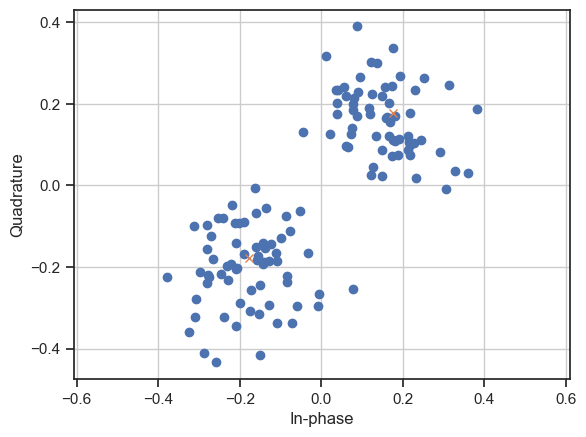

In [33]:
plt.plot(rn.real, rn.imag, 'o')
plt.plot(np.real(X*Alphabet), np.imag(X*Alphabet), 'x')
plt.grid()
plt.axis('equal')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

Received training signal is very noisy. Constellation is rotated 45 degrees.

## FInding $\hat{X}$

To find the solution to the transcendental equation we use an iterative technique. In each iteration, the result from the prior iteration is used to refine the solution. It is usually enough to stop after a small number of such iterations. To begin, an arbitrary starting point is selected.

In [36]:
## iterative solution of transcendental equation
sigma_sq = A**2/SNR
N_iter = 5

# starting value
X_hat = 1. + 0.j

for n in range(N_iter):
    X_hat = np.mean(rn * np.tanh(np.real(np.conj(X_hat)*rn)/sigma_sq))
    print("After iteration {:1d}: X_hat = {:5.4f} + j {:5.4f}, A = {:5.4f}, phi = {:5.4f} *pi".format(n+1, X_hat.real, X_hat.imag, np.abs(X_hat), np.angle(X_hat)/np.pi))

print("\nFinal Estimate: A = {:5.4f}, phi = {:5.4f} *pi".format(np.abs(X_hat), np.angle(X_hat)/np.pi))

After iteration 1: X_hat = 0.1684 + j 0.1722, A = 0.2408, phi = 0.2536 *pi
After iteration 2: X_hat = 0.1649 + j 0.1805, A = 0.2444, phi = 0.2644 *pi
After iteration 3: X_hat = 0.1649 + j 0.1807, A = 0.2446, phi = 0.2645 *pi
After iteration 4: X_hat = 0.1649 + j 0.1807, A = 0.2446, phi = 0.2646 *pi
After iteration 5: X_hat = 0.1649 + j 0.1807, A = 0.2446, phi = 0.2646 *pi

Final Estimate: A = 0.2446, phi = 0.2646 *pi
